Wind characteristics are the most important control in aeolian environments. Wind regime and sand transport potential play a crucial rule to determine the evolution and dynamics of aeolian processes and landforms. In this exercise, we will:  
- analyse wind data from a meteorological station and make wind roses;
- use the Law of the Wall to determine the roughness length;
- then, calculate resultant drift potential, resultant drift direction and wind directional variability.

In [2]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from math import pi

In [4]:
# read the data
# Average 6-hourly wind velocities from 1957 to 2003 were acquired from the meteorological station in Dongsheng, Inner Mongolia.
# Wind directions were recorded in 16 directions.
# 1 to 16 represents wind from NNE, NE, ENE ... in the clockwise direction. So 22.5 degree intervals. 17 means no wind.
df = pd.read_csv("https://raw.githubusercontent.com/Na-Leeds/BSc_Data_to_Insights_Aeolian/refs/heads/main/raw%20data%20wind%20Dongsheng.csv")

In [5]:
# check the first 5 rows of data
df.head()

,year,month,day,time,direction,speed
0,1957,1,1,2,10,3
1,1957,1,1,8,10,4
2,1957,1,1,14,11,3
3,1957,1,1,20,9,5
4,1957,1,2,2,17,0


In [ ]:
# check the first 10 rows of data
df.head(10)

,year,month,day,time,direction,speed
0,1957,1,1,2,10,3
1,1957,1,1,8,10,4
2,1957,1,1,14,11,3
3,1957,1,1,20,9,5
4,1957,1,2,2,17,0
5,1957,1,2,8,17,0
6,1957,1,2,14,16,6
7,1957,1,2,20,1,2
8,1957,1,3,2,1,3
9,1957,1,3,8,16,6


In [ ]:
# summary statistics
df.describe()

,year,month,day,time,direction,speed
count,68659.000000,68659.000000,68659.000000,68659.000000,68659.000000,68659.000000
mean,1980.001398,6.523311,15.729067,11.000655,16.729023,3.258801
std,13.563690,3.448652,8.799926,6.708057,467.721023,2.228501
min,1957.000000,1.000000,1.000000,2.000000,1.000000,0.000000
25%,1968.000000,4.000000,8.000000,8.000000,8.000000,2.000000
50%,1980.000000,7.000000,16.000000,14.000000,10.000000,3.000000
75%,1992.000000,10.000000,23.000000,20.000000,14.000000,4.000000
max,2003.000000,12.000000,31.000000,20.000000,32766.000000,20.000000


In [ ]:
# check data types
df.dtypes

year         int64
month        int64
day          int64
time         int64
direction    int64
speed        int64
dtype: object

In [ ]:
# check the size of data
df.shape

(68659, 6)

In [ ]:
df.loc[df['direction']>17]

,year,month,day,time,direction,speed
43668,1986,11,23,8,32766,5
43669,1986,11,23,14,32766,2
43670,1986,11,23,20,32766,1
43671,1986,11,24,2,32766,2
43672,1986,11,24,8,32766,1
43673,1986,11,24,14,32766,3
43674,1986,11,24,20,32766,1
43675,1986,11,25,2,32766,1
43676,1986,11,25,8,32766,1
43677,1986,11,25,14,32766,2


In [ ]:
# delete rows with odd direction
df = df.drop(df[df['direction']>17].index)

In [ ]:
# check the size of data again
df.shape

(68645, 6)

In [ ]:
# check data
df.min()

year         1957
month           1
day             1
time            2
direction       1
speed           0
dtype: int64

In [ ]:
df.max()

year         2003
month          12
day            31
time           20
direction      17
speed          20
dtype: int64

In [ ]:
!pip install windrose

In [ ]:
df['dir_compass'] = df['direction']*22.5

<Axes: >

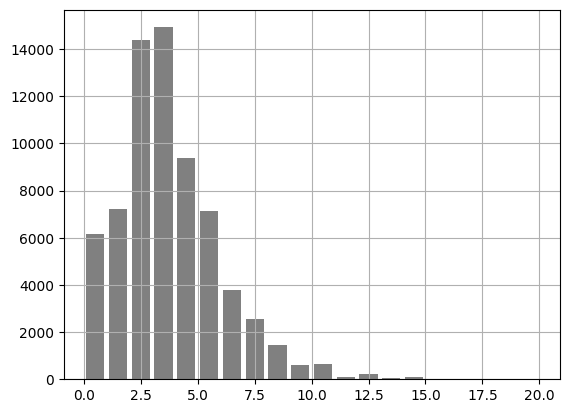

In [ ]:
# plot histogram of wind speed
df['speed'].hist(bins = 20, rwidth=0.8, color = 'grey')

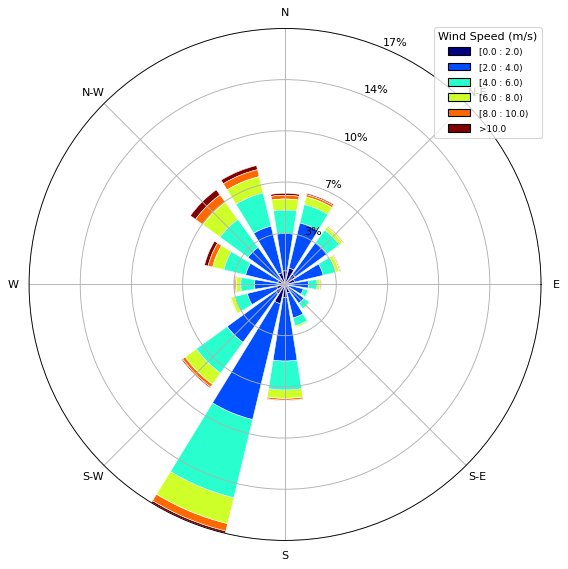

In [ ]:
from windrose import WindroseAxes, plot_windrose
# plot windrose in bar mode, in percent
ax = WindroseAxes.from_ax()

ax.bar(df.dir_compass, df.speed, bins = np.array([0, 2, 4, 6, 8, 10]), normed=True, opening=0.8, cmap=cm.jet, linewidth=0.5, edgecolor='white')
ax.set_legend(title = 'Wind Speed (m/s)', loc='best')

# Format radius axis to percentages
import matplotlib.ticker as mtick
fmt = '%.0f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

plt.show()

# check this link and choose your favorite different colourmap: schemhttps://matplotlib.org/stable/gallery/color/colormap_reference.html

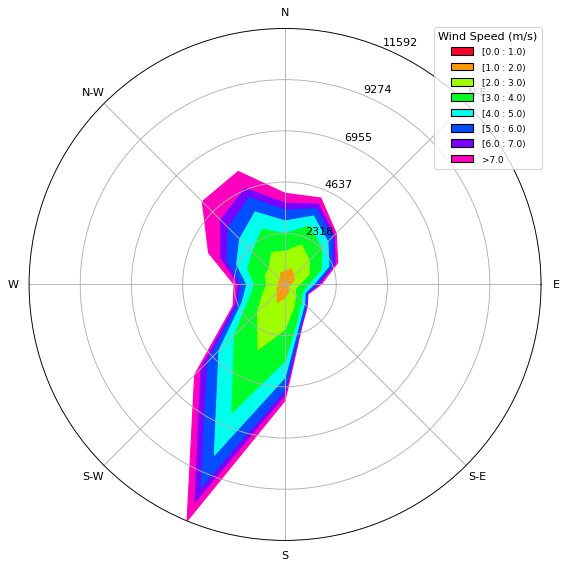

In [ ]:
# plot windrose in filled mode, in bin limits
ax = WindroseAxes.from_ax()
ax.contourf(df.dir_compass, df.speed, bins=np.arange(0, 8, 1), cmap=cm.gist_rainbow)
ax.set_legend(title = 'Wind Speed (m/s)', loc='best')

# # Format radius axis
fmt = '%.0f'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

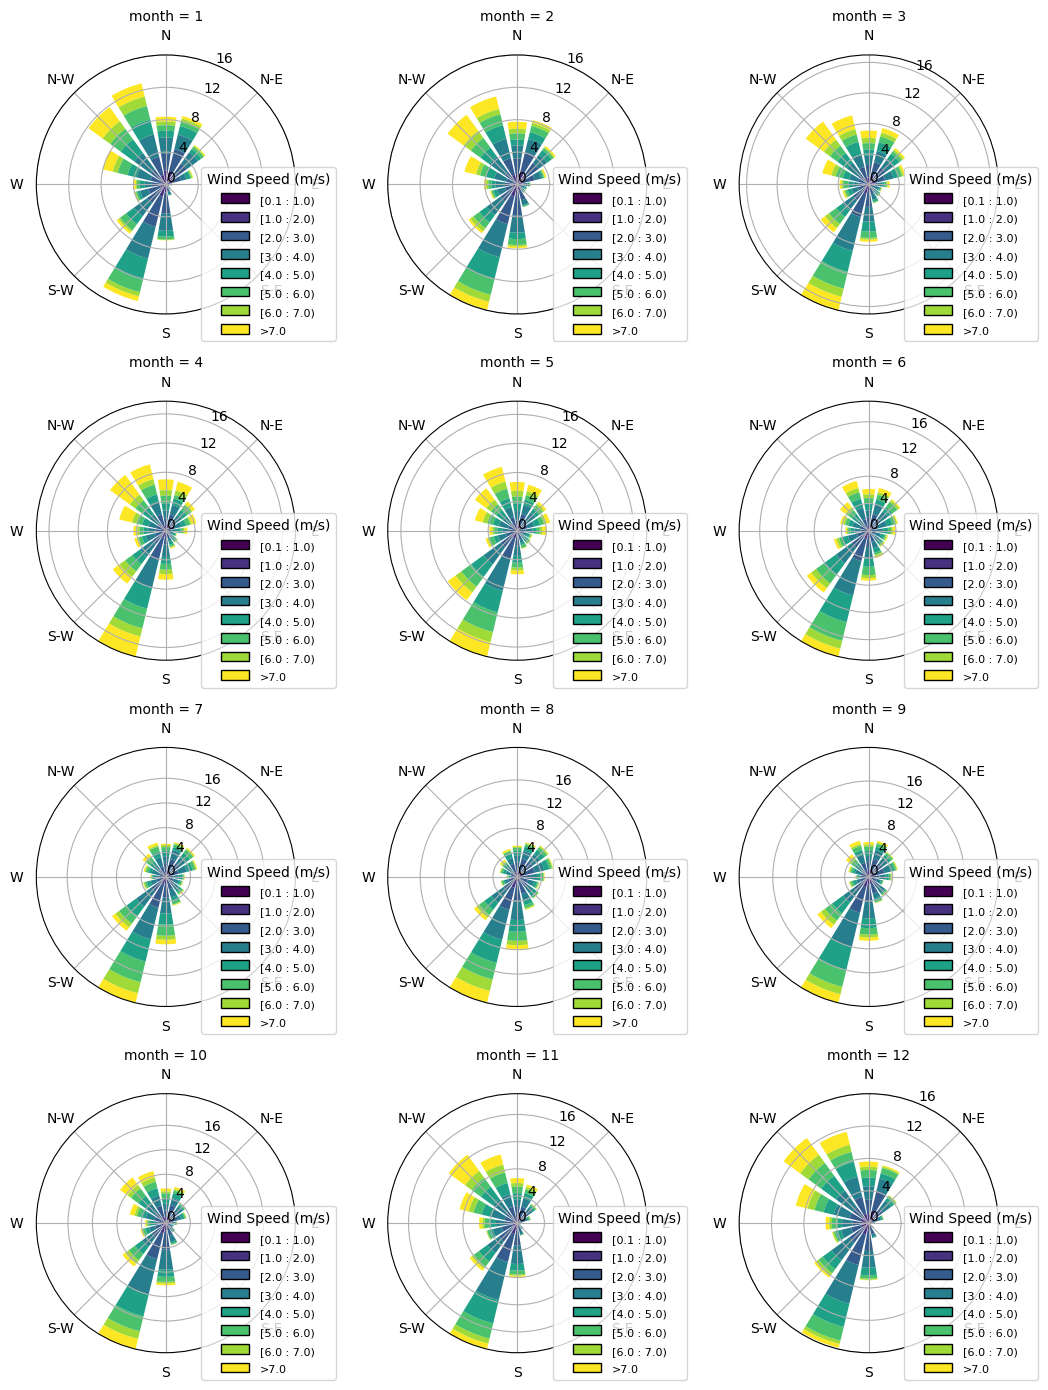

In [ ]:
# plot windrose for each month
def plot_windrose_subplots(data, *, direction, var, color=None, **kwargs):
    """wrapper function to create subplots per axis"""
    ax = plt.gca()
    ax = WindroseAxes.from_ax(ax=ax)
    plot_windrose(direction_or_df=data[direction], var=data[var], ax=ax, **kwargs)


# this creates the raw subplot structure with a subplot per value in month.
g = sns.FacetGrid(
    data=df,
    # the column name for each level a subplot should be created
    col="month",
    # place a maximum of 3 plots per row
    col_wrap=3,
    subplot_kws={"projection": "windrose"},
    sharex=False,
    sharey=False,
    despine=False,
    height=3.5,
)

g.map_dataframe(
    plot_windrose_subplots,
    direction="dir_compass",
    var="speed",
    normed=True,
    # manually set bins, so they match for each subplot
    bins=(0.1, 1, 2, 3, 4, 5, 6, 7),
    calm_limit=0.1,
    kind="bar",
)

# make the subplots easier to compare, by having the same y-axis range
y_ticks = range(0, 20, 4)
for ax in g.axes:
    ax.set_legend(
        title='Wind Speed (m/s)', bbox_to_anchor=(1.15, -0.1), loc="lower right"
    )
    ax.set_rgrids(y_ticks, y_ticks)

# adjust the spacing between the subplots to have sufficient space between plots
plt.subplots_adjust(wspace=0.2)

# The Law of the wall. In order to caculate the
## The threshold velocity at the height of 10.4 m, where cup anemometers were set up at the Dongsheng meteorological station, can be estimated by substituting the threshold value of shear velocity (u_(*t)) for the shear velocity (u_*) using the Law of the Wall, if the roughness length of the surface (z0) is known.
	u=  u_*/κ ln⁡(z/z_0 )
- Where u is the velocity at the height z;
- κ is von Karman’s constant. 0.4.


In [ ]:
# The law of the wall
df_wind = pd.read_csv(r"C:\Users\44797\Desktop\Dune teaching\windprofile.csv")

In [ ]:
# check the data
df_wind.head()

,H,v1,v2,v3,v4,v5,v6,v7
0,0.6,4.399,5.131,4.874,5.918,5.973,4.999,5.475
1,1.0,4.887,5.642,5.253,6.390,6.406,5.377,5.818
2,1.2,5.038,5.751,5.265,6.480,6.536,5.346,5.974
3,1.5,5.095,5.856,5.533,6.802,6.831,5.673,6.210
4,2.0,5.346,6.177,5.766,7.190,7.146,5.929,6.481


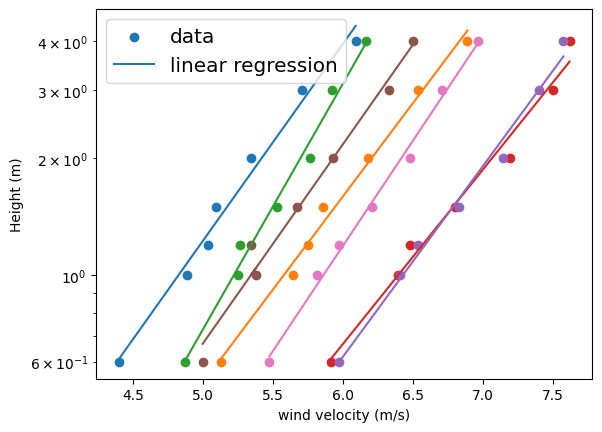

In [ ]:
from sklearn.metrics import r2_score

df_wind_results = pd.DataFrame(index = range(7), columns=['r_squared', 'shear_v', 'z0'])
# fig, ax = plt.subplot(ncols=2, nrows=2, figsize=(5.5, 3.5), layout="constrained")
plt.figure()
for idata in list(range(0,df_wind.shape[0],1)):
    # perform linear regression
    x_data = df_wind.iloc[:, idata+1]
    y_data = np.log(df_wind['H'])
    slope, intercept = np.polyfit(x_data, y_data, 1)

    # calculate predicted values using the regression equation
    y_predicted = slope * x_data + intercept

    # Calculate R-squared value
    r_squared = r2_score(y_data, y_predicted)
    shear_v = 0.4/slope
    z0 = np.exp(intercept)

    df_wind_results.iloc[idata, 0] = r_squared
    df_wind_results.iloc[idata, 1] = shear_v
    df_wind_results.iloc[idata, 2] = z0


    # Plot the data and regression line
    plt.scatter(x_data, df_wind['H'])
    plt.plot(x_data, np.exp(y_predicted))

# format figure
plt.yscale("log")
plt.xlabel('wind velocity (m/s)')
plt.ylabel('Height (m)')
plt.legend(["data","linear regression"], fontsize="x-large")
plt.show()


In [ ]:
# show results
df_wind_results.head()

,r_squared,shear_v,z0
0,0.984991,0.342569,0.003574
1,0.991525,0.361876,0.002104
2,0.986164,0.274525,0.000497
3,0.983162,0.386915,0.001348
4,0.98863,0.353864,0.0007


In [ ]:
# calculate shear velocity at the height = 10.4m where meteorological station is located
threshold_shear_v = 0.19
z0_mean = df_wind_results['z0'].mean()
shear_v_station = threshold_shear_v/0.4*math.log(10.4/z0_mean)
print(shear_v_station)

4.191182917884401


In [ ]:
# calculate drift potential for each direction
df['DP'] = df['speed']*df['speed']*(df['speed']-shear_v_station)*1/df.shape[0]

# change negative DP to zero
df.loc[df['DP']<0, 'DP'] = 0

# check DP
df['DP'].describe()

count    68645.000000
mean         0.000506
std          0.002275
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.092119
Name: DP, dtype: float64

In [ ]:
# summarise DP for each wind direction
df_DP = pd.DataFrame()
df_DP['dir'] = list(range(1, 17, 1))
df_DP['DP'] = np.nan

for dir in list(range(1, 17, 1)):
    DP_sum = df.loc[df['direction'] == dir, 'DP'].sum()
    df_DP.iloc[dir-1, 1] = DP_sum

print(df_DP)

    dir        DP
0     1  1.814789
1     2  0.678040
2     3  0.852523
3     4  0.580729
4     5  0.151287
5     6  0.183484
6     7  0.234354
7     8  1.259166
8     9  4.950649
9    10  2.233001
10   11  0.549520
11   12  1.125117
12   13  4.255246
13   14  8.047586
14   15  5.110324
15   16  2.698180


In [ ]:
df_DP['dir_compass'] = df_DP['dir']*22.5
print(df_DP)

    dir        DP  dir_compass
0     1  1.814789         22.5
1     2  0.678040         45.0
2     3  0.852523         67.5
3     4  0.580729         90.0
4     5  0.151287        112.5
5     6  0.183484        135.0
6     7  0.234354        157.5
7     8  1.259166        180.0
8     9  4.950649        202.5
9    10  2.233001        225.0
10   11  0.549520        247.5
11   12  1.125117        270.0
12   13  4.255246        292.5
13   14  8.047586        315.0
14   15  5.110324        337.5
15   16  2.698180        360.0


In [ ]:
# cacluate RDP, remember compass direction is different from normal x,y direction (0 at 90 degree)
df_DP['DP_n'] = np.nan
df_DP['DP_e'] = np.nan
for i in list(range(0, 16, 1)):
    df_DP.iloc[i,3] =  df_DP.iloc[i,1] * math.cos(math.radians(df_DP.iloc[i, 2]))
    df_DP.iloc[i,4] =  df_DP.iloc[i,1] * math.sin(math.radians(df_DP.iloc[i, 2]))

RDP_n = df_DP['DP_n'].sum()
RDP_e = df_DP['DP_e'].sum()
RDP = math.sqrt(math.pow(df_DP['DP_n'].sum(), 2) + math.pow(df_DP['DP_e'].sum(), 2))
RDP_dir = math.degrees(math.atan2(RDP_n,RDP_e)) # direction of RDP is direction of wind blows to (not from)
RDP2DP = RDP/df_DP['DP'].sum()

print(RDP_n, RDP_e, RDP, RDP_dir, RDP2DP)

9.194373817817922 -13.782291959397202 16.567681840132025 146.2921520876781 0.47712488683530785


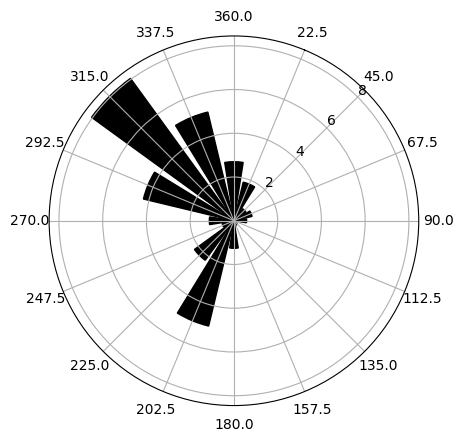

In [ ]:
# Plot DP in polar plot
theta = np.linspace(0, 2*np.pi, 16, endpoint=False)
directions = df_DP['dir_compass']

ax = plt.subplot(polar=True)
ax.bar(theta, df_DP['DP'], width=2*pi/16*0.8, linewidth=1, edgecolor='k', alpha=1, color = 'k')

ax.set_xticks(theta)
ax.set_xticklabels(directions)
ax.set_yticks([2,4,6,8])
ax.set_yticklabels([2,4,6,8])

# set change in clockwise direction and zero at the north direction
ax.set_theta_offset(math.radians(45+22.5))
ax.set_theta_direction(-1)



In [ ]:
df_DP

,dir,DP,dir_compass,DP_n,DP_e
0,1,1.814789,22.5,1.676646e+00,6.944896e-01
1,2,0.678040,45.0,4.794469e-01,4.794469e-01
2,3,0.852523,67.5,3.262463e-01,7.876282e-01
3,4,0.580729,90.0,3.555937e-17,5.807286e-01
4,5,0.151287,112.5,-5.789497e-02,1.397708e-01
5,6,0.183484,135.0,-1.297430e-01,1.297430e-01
6,7,0.234354,157.5,-2.165146e-01,8.968330e-02
7,8,1.259166,180.0,-1.259166e+00,1.542034e-16
8,9,4.950649,202.5,-4.573803e+00,-1.894531e+00
9,10,2.233001,225.0,-1.578970e+00,-1.578970e+00


In [ ]:
# calculate DP for each month
df_DP['DP_Jan'] = np.nan
df_DP['DP_Feb'] = np.nan
df_DP['DP_Mar'] = np.nan
df_DP['DP_Apr'] = np.nan
df_DP['DP_May'] = np.nan
df_DP['DP_Jun'] = np.nan
df_DP['DP_Jul'] = np.nan
df_DP['DP_Aug'] = np.nan
df_DP['DP_Sep'] = np.nan
df_DP['DP_Oct'] = np.nan
df_DP['DP_Nov'] = np.nan
df_DP['DP_Dec'] = np.nan

# create dataframe with 16 rows (wind directions), and 12 coloumns (12 months)
df_DP_n = pd.DataFrame(index = range(16), columns=['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
df_DP_e = pd.DataFrame(index = range(16), columns=['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
RDP_month = pd.DataFrame(index = range(12), columns=['RDP', 'Dir'])

for j in list(range(1,13,1)):
    df_month = df.loc[df['month'] == j]

    for i in list(range(1, 17, 1)):
        DP_sum = df_month.loc[df_month['direction'] == i, 'DP'].sum()
        df_DP.iloc[i-1,j+4] = DP_sum
        df_DP_n.iloc[i-1,j-1] = DP_sum * math.cos(math.radians(df_DP.iloc[i-1, 2]))
        df_DP_e.iloc[i-1,j-1] = DP_sum * math.sin(math.radians(df_DP.iloc[i-1, 2]))

# check results
RDP_month_n = df_DP_n.sum()
RDP_month_e = df_DP_e.sum()

for k in list(range(0, 12, 1)):
    RDP = math.sqrt(math.pow(RDP_month_n.iloc[k], 2) + math.pow(RDP_month_e.iloc[k], 2))
    Dir = math.degrees(math.atan2(RDP_month_n.iloc[k], RDP_month_e.iloc[k])) # direction of RDP is direction of wind blows to (not from)
    if Dir < 0:
        Dir = Dir + 180
    RDP_month.iloc[k,0] = RDP
    RDP_month.iloc[k,1] = Dir

print(RDP_month)

         RDP         Dir
0   1.798892  134.728928
1    1.83871  139.338916
2   2.413269  142.312124
3   2.931141  138.652713
4   1.671226  134.624354
5   0.673676  138.615433
6   0.598228   46.643148
7   0.580595   57.229313
8    0.48056   12.929708
9   0.992587  167.639218
10  2.054454  142.871612
11  1.976358  140.772992


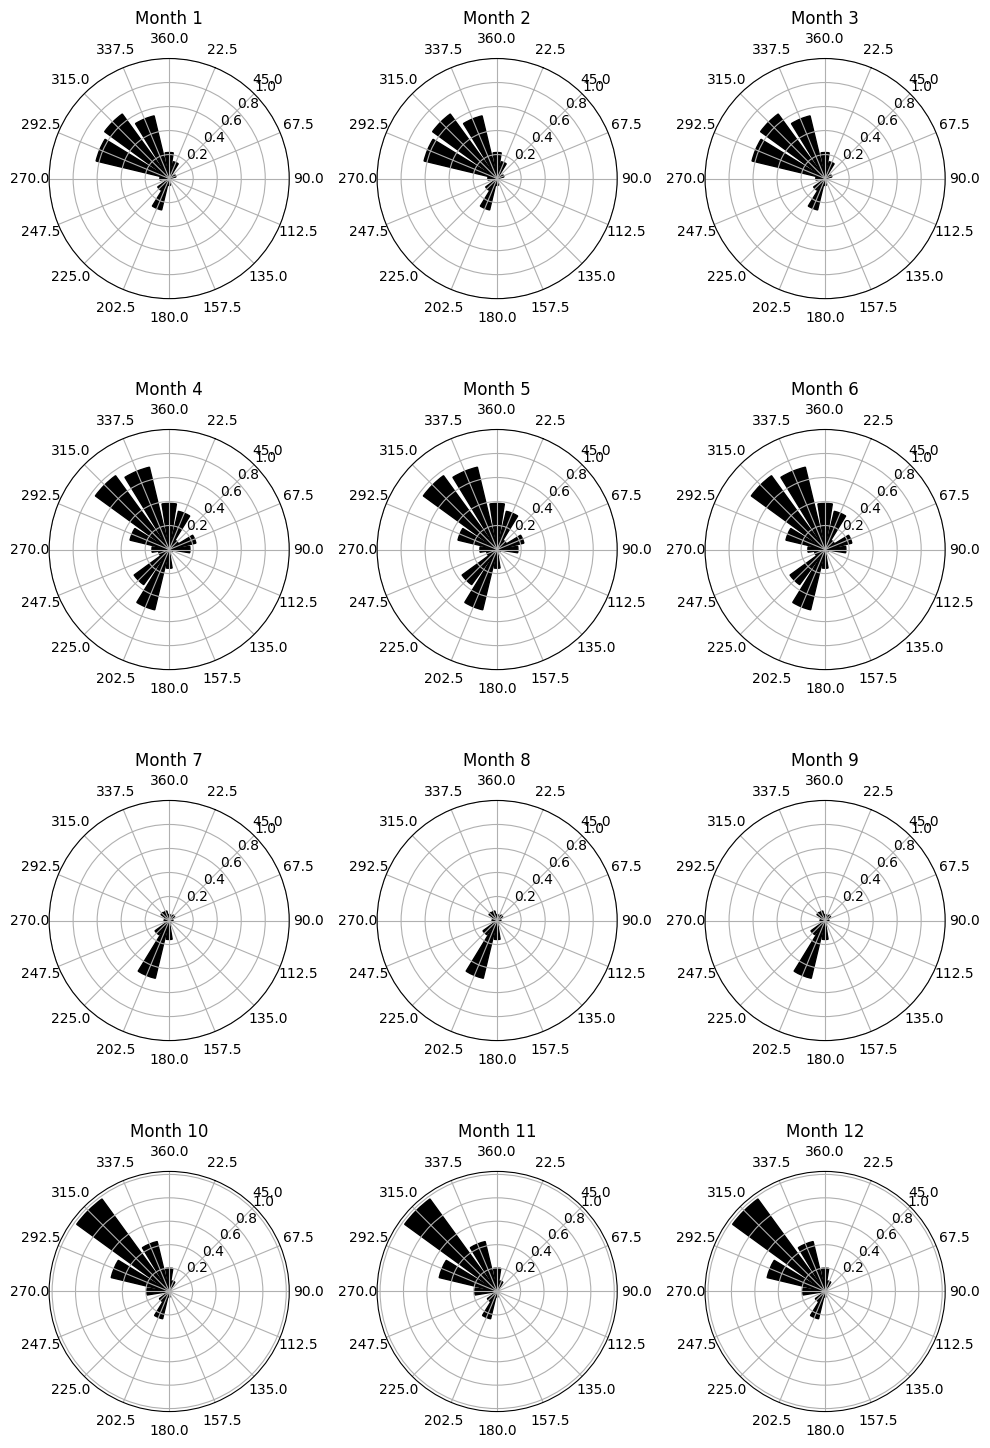

<Figure size 60000x5000 with 0 Axes>

In [ ]:
# plot DP for each month
theta = np.linspace(0, 2*np.pi, 16, endpoint=False)
directions = df_DP['dir_compass']
fig, axs = plt.subplots(4, 3, subplot_kw = {'projection' : 'polar'}, figsize=(10, 15))
grid = plt.GridSpec(4, 3, wspace=0.2, hspace=1)
plt.figure(figsize=[600,50])
for j in range(4):
    for i in range(3):
        month = j*3 + i + 1

        #ax[j,i] = plt.subplot(polar=True)
        axs[j,i].bar(theta, df_DP.iloc[: ,5+month-i], width=2*pi/16*0.8, linewidth=1, edgecolor='k', alpha=1, color = 'k')
        axs[j,i].set_xticks(theta)
        axs[j,i].set_xticklabels(directions)
        axs[j,i].set_yticks([0.2,0.4,0.6,0.8,1.0])
        axs[j,i].set_yticklabels([0.2,0.4,0.6,0.8,1.0])
        # set change in clockwise direction and zero at the north direction
        axs[j,i].set_theta_offset(math.radians(45+22.5))
        axs[j,i].set_theta_direction(-1)
        axs[j,i].title.set_text(f'Month {month}')

#plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.1)
fig.tight_layout(h_pad=1, w_pad=1)